Execute this cell below only when hosting code remotely.
This cell lets you import all code from https://github.com/maviddoerdijk/bsc-thesis/blob/main/src/.

Warning: when hosting remotely, none of the helper function code can be changed. Unless when you use specific branches.


In [142]:
branch = "main"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git
# %cd bsc-thesis/src

Cloning into 'bsc-thesis'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 139 (delta 69), reused 60 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (139/139), 4.12 MiB | 6.13 MiB/s, done.
Resolving deltas: 100% (69/69), done.


Now, let's start the notebook.

In [7]:
# Install missing Python packages in Google Colab
!pip install ta
!pip install prophet
!pip install pykalman
!pip install PyWavelets

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=95f514dd93125bc8281bcb5dd010f44a54d31ee64a3b822ce1b00c87e26d9f3b
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 47.3 MB/s eta 0:00:00


In [143]:
# Import all packages
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import time
import ta # technical indicators
import statsmodels.api as sm
import pywt
import pandas as pd


# Custom helper functions
from data.data_collection import gather_data
from preprocessing.cointegration import find_cointegrated_pairs
from utils.visualization import plot_heatmap
from preprocessing.technical_indicators import add_technical_indicators
from preprocessing.ols import add_OLS

ImportError: cannot import name 'add_technical_indicators' from 'preprocessing.technical_indicators' (/content/bsc-thesis/src/preprocessing/technical_indicators.py)

# Gather data

In [64]:
def fetch_live_etf_tickers():
    base_url = "https://finance.yahoo.com/research-hub/screener/etf/?start={}&count=25"
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
                      'AppleWebKit/537.36 (KHTML, like Gecko) '
                      'Chrome/122.0.0.0 Safari/537.36'
    }

    all_tickers = set()

    for start in range(0, 875, 25):  # 0 to 850 (inclusive) - in this case we know the webpage shows a total of 871 ETFs.
        url = base_url.format(start)
        print(f"Fetching: {url}")

        response = requests.get(url, headers=headers)
        if response.status_code != 200:
            print(f"Failed to fetch page {start}: {response.status_code}")
            continue
        current_tickers = set() # check amount of tickers per page

        soup = BeautifulSoup(response.text, 'html.parser')
        for a_tag in soup.find_all('a', {'data-testid': 'table-cell-ticker'}):
            href = a_tag.get('href', '')
            if href.startswith('/quote/') and href.endswith('/'):
                ticker = href.split('/')[2]
                all_tickers.add(ticker)
                current_tickers.add(ticker)
        print(f"Found {len(current_tickers)} tickers on page {start}")

        time.sleep(1)  #  wait a bit to avoid rate-limiting - this worked well enough

    return sorted(all_tickers)

def load_cached_etf_tickers():
  return list(set(['AADR', 'AAPB', 'AAVM', 'AAXJ', 'ABCS', 'ABIG', 'ACWI', 'ACWX', 'ADBG', 'AFSC', 'AGIX', 'AGMI', 'AGNG', 'AGZD', 'AIA', 'AIPI', 'AIQ', 'AIRL', 'AIRR', 'ALIL', 'ALLW', 'AMDD', 'AMDG', 'AMDL', 'AMDS', 'AMID', 'AMUU', 'AMZD', 'AMZU', 'AMZZ', 'ANGL', 'AOHY', 'AOTG', 'APED', 'AQWA', 'ARMG', 'ARVR', 'ASET', 'ASMG', 'AUMI', 'AVGB', 'AVGX', 'AVL', 'AVS', 'AVUQ', 'AVXC', 'BABX', 'BAFE', 'BBH', 'BCLO', 'BDGS', 'BEEX', 'BEEZ', 'BELT', 'BGRN', 'BGRO', 'BIB', 'BIS', 'BITS', 'BJK', 'BKCH', 'BKIV', 'BKWO', 'BLCN', 'BLCR', 'BMAX', 'BND', 'BNDW', 'BNDX', 'BOTT', 'BOTZ', 'BRHY', 'BRKD', 'BRKU', 'BRNY', 'BRRR', 'BRTR', 'BSCP', 'BSCQ', 'BSCR', 'BSCS', 'BSCT', 'BSCU', 'BSCV', 'BSCW', 'BSCX', 'BSCY', 'BSJP', 'BSJQ', 'BSJR', 'BSJS', 'BSJT', 'BSJU', 'BSJV', 'BSJW', 'BSMP', 'BSMQ', 'BSMR', 'BSMS', 'BSMT', 'BSMU', 'BSMV', 'BSMW', 'BSMY', 'BSVO', 'BTF', 'BTFX', 'BTGD', 'BUFC', 'BUFM', 'BUG', 'BULD', 'CA', 'CAFG', 'CALI', 'CANC', 'CANQ', 'CARY', 'CATH', 'CCNR', 'CCSB', 'CDC', 'CDL', 'CEFA', 'CFA', 'CFO', 'CHGX', 'CHPS', 'CIBR', 'CIL', 'CLOA', 'CLOD', 'CLOU', 'CLSM', 'CNCR', 'COIG', 'COMT', 'CONI', 'CONL', 'COPJ', 'COPP', 'CORO', 'COWG', 'COWS', 'CPLS', 'CRMG', 'CRWL', 'CSA', 'CSB', 'CTEC', 'CXSE', 'CZAR', 'DALI', 'DAPP', 'DAX', 'DECO', 'DEMZ', 'DFGP', 'DFGX', 'DGCB', 'DGRE', 'DGRS', 'DGRW', 'DIVD', 'DLLL', 'DMAT', 'DMXF', 'DRIV', 'DTCR', 'DUKH', 'DUKX', 'DVAL', 'DVOL', 'DVQQ', 'DVY', 'DWAS', 'DWSH', 'DWUS', 'DYNI', 'DYTA', 'EBI', 'ECOW', 'EEMA', 'EFAS', 'EGGQ', 'EHLS', 'EKG', 'ELFY', 'ELIL', 'ELIS', 'EMB', 'EMEQ', 'EMIF', 'EMXC', 'EMXF', 'ENDW', 'EQRR', 'ERET', 'ERNZ', 'ESGD', 'ESGE', 'ESGU', 'ESMV', 'ESPO', 'ETEC', 'ETHA', 'EUFN', 'EVMT', 'EVSD', 'EVYM', 'EWJV', 'EWZS', 'EYEG', 'FAAR', 'FAB', 'FAD', 'FALN', 'FBL', 'FBOT', 'FBZ', 'FCA', 'FCAL', 'FCEF', 'FCTE', 'FDCF', 'FDFF', 'FDIG', 'FDIV', 'FDNI', 'FDT', 'FDTX', 'FEAT', 'FEM', 'FEMB', 'FEMS', 'FEP', 'FEPI', 'FEUZ', 'FEX', 'FGM', 'FICS', 'FID', 'FINE', 'FINX', 'FIVY', 'FIXD', 'FJP', 'FKU', 'FLDB', 'FLN', 'FMB', 'FMED', 'FMHI', 'FMTM', 'FMUB', 'FMUN', 'FNK', 'FNX', 'FNY', 'FPA', 'FPXE', 'FPXI', 'FSCS', 'FSZ', 'FTA', 'FTAG', 'FTC', 'FTCS', 'FTDS', 'FTGC', 'FTGS', 'FTHI', 'FTQI', 'FTRI', 'FTSL', 'FTSM', 'FTXG', 'FTXH', 'FTXL', 'FTXN', 'FTXO', 'FV', 'FVC', 'FYC', 'FYT', 'FYX', 'GBUG', 'GFLW', 'GGLL', 'GGLS', 'GIND', 'GLCR', 'GLDI', 'GLDY', 'GLOW', 'GNMA', 'GNOM', 'GOVI', 'GPIQ', 'GPIX', 'GQQQ', 'GRID', 'GSIB', 'GTR', 'GXDW', 'HCOW', 'HECO', 'HEQQ', 'HERD', 'HERO', 'HFSP', 'HIDE', 'HIMZ', 'HISF', 'HLAL', 'HNDL', 'HOOG', 'HOOX', 'HRTS', 'HWAY', 'HYBI', 'HYDR', 'HYLS', 'HYXF', 'HYZD', 'IBAT', 'IBB', 'IBBQ', 'IBGA', 'IBGB', 'IBGK', 'IBGL', 'IBIT', 'IBOT', 'IBTF', 'IBTG', 'IBTH', 'IBTI', 'IBTJ', 'IBTK', 'IBTL', 'IBTM', 'IBTO', 'IBTP', 'IBTQ', 'ICLN', 'ICOP', 'IEF', 'IEI', 'IEUS', 'IFGL', 'IFV', 'IGF', 'IGIB', 'IGOV', 'IGSB', 'IHYF', 'IJT', 'ILIT', 'IMCV', 'IMOM', 'INDH', 'INDY', 'INFR', 'INRO', 'INTW', 'IONL', 'IONX', 'IPKW', 'IQQQ', 'ISHG', 'ISHP', 'ISTB', 'IUS', 'IUSB', 'IUSG', 'IUSV', 'IVAL', 'IVEG', 'IWTR', 'IXUS', 'JDOC', 'JEPQ', 'JGLO', 'JIVE', 'JMID', 'JPEF', 'JPY', 'JSMD', 'JSML', 'JTEK', 'KBAB', 'KBWB', 'KBWD', 'KBWP', 'KBWR', 'KBWY', 'KNGZ', 'KPDD', 'KQQQ', 'KRMA', 'KROP', 'LAYS', 'LDEM', 'LDSF', 'LEGR', 'LEXI', 'LFSC', 'LGCF', 'LGRO', 'LITP', 'LIVR', 'LMBS', 'LRGE', 'LRND', 'LVHD', 'MAXI', 'MBB', 'MBS', 'MCDS', 'MCHI', 'MCHS', 'MCSE', 'MDIV', 'MEDX', 'MEMS', 'METD', 'MFLX', 'MILN', 'MKAM', 'MNTL', 'MODL', 'MOOD', 'MQQQ', 'MRAL', 'MSFD', 'MSFL', 'MSFU', 'MSTX', 'MUD', 'MULL', 'MUU', 'MVLL', 'MYCF', 'MYCG', 'MYCH', 'MYCI', 'MYCJ', 'MYCK', 'MYCL', 'MYCM', 'MYCN', 'MYMG', 'MYMH', 'MYMI', 'MYMJ', 'NATO', 'NCIQ', 'NCPB', 'NERD', 'NEWZ', 'NFTY', 'NFXS', 'NIKL', 'NIXT', 'NPFI', 'NSI', 'NUSB', 'NVDD', 'NVDG', 'NVDL', 'NVDS', 'NVDU', 'NXTG', 'NZAC', 'NZUS', 'OBIL', 'ODDS', 'ONEQ', 'OOQB', 'OOSB', 'OPTZ', 'ORCX', 'ORR', 'OZEM', 'PABD', 'PABU', 'PALU', 'PANG', 'PATN', 'PBQQ', 'PCMM', 'PDBA', 'PDBC', 'PDP', 'PEPS', 'PEY', 'PEZ', 'PFF', 'PFM', 'PGJ', 'PHO', 'PID', 'PIE', 'PIO', 'PIZ', 'PKW', 'PLTD', 'PLTU', 'PMBS', 'PNQI', 'PPH', 'PPI', 'PQAP', 'PQJA', 'PQJL', 'PQOC', 'PRFZ', 'PRN', 'PSC', 'PSCC', 'PSCD', 'PSCE', 'PSCF', 'PSCH', 'PSCI', 'PSCM', 'PSCT', 'PSCU', 'PSET', 'PSL', 'PSTR', 'PSWD', 'PTF', 'PTH', 'PTIR', 'PTNQ', 'PUI', 'PXI', 'PY', 'PYPG', 'PYZ', 'QABA', 'QBIG', 'QBUF', 'QCLN', 'QCLR', 'QCML', 'QDTY', 'QHDG', 'QMOM', 'QNXT', 'QOWZ', 'QQA', 'QQEW', 'QQJG', 'QQLV', 'QQQ', 'QQQA', 'QQQE', 'QQQG', 'QQQH', 'QQQI', 'QQQJ', 'QQQM', 'QQQP', 'QQQS', 'QQQT', 'QQQY', 'QQXT', 'QRMI', 'QSIX', 'QSML', 'QTEC', 'QTOP', 'QTR', 'QTUM', 'QVAL', 'QYLD', 'QYLG', 'RAA', 'RAYS', 'RDTL', 'RDTY', 'RDVY', 'REAI', 'REIT', 'RFDI', 'RFEU', 'RGTX', 'RING', 'RKLX', 'RNEM', 'RNEW', 'RNRG', 'ROBT', 'ROE', 'RTH', 'RUNN', 'SARK', 'SCZ', 'SDG', 'SDTY', 'SDVY', 'SEEM', 'SEIE', 'SEIS', 'SFLO', 'SHRY', 'SHV', 'SHY', 'SIXG', 'SKOR', 'SKRE', 'SKYU', 'SKYY', 'SLQD', 'SLVO', 'SLVR', 'SMCF', 'SMCL', 'SMCO', 'SMCX', 'SMCZ', 'SMH', 'SMRI', 'SMST', 'SNSR', 'SOCL', 'SOFX', 'SOLT', 'SOLZ', 'SOXQ', 'SOXX', 'SPAM', 'SPAQ', 'SPCX', 'SPCY', 'SPRX', 'SPYQ', 'SQLV', 'SQQQ', 'SRET', 'STNC', 'SUSB', 'SUSC', 'SUSL', 'TARK', 'TAX', 'TAXE', 'TBIL', 'TCHI', 'TDI', 'TDIV', 'TDSC', 'TEKX', 'TEKY', 'THMZ', 'TLT', 'TMET', 'TPLS', 'TQQQ', 'TQQY', 'TSEL', 'TSL', 'TSLG', 'TSLL', 'TSLQ', 'TSLR', 'TSLS', 'TSMG', 'TSMU', 'TSMX', 'TSMZ', 'TSPY', 'TSYY', 'TTEQ', 'TUG', 'TUGN', 'TUR', 'TXSS', 'TXUE', 'TXUG', 'UAE', 'UBND', 'UBRL', 'UCYB', 'UEVM', 'UFIV', 'UFO', 'UITB', 'UIVM', 'ULVM', 'UMMA', 'UPGR', 'URNJ', 'USAF', 'USCL', 'USDX', 'USIG', 'USMC', 'USOI', 'USRD', 'USSH', 'USTB', 'USVM', 'USVN', 'USXF', 'UTEN', 'UTHY', 'UTRE', 'UTWO', 'UTWY', 'UYLD', 'VBIL', 'VCIT', 'VCLT', 'VCRB', 'VCSH', 'VFLO', 'VGIT', 'VGLT', 'VGSH', 'VGSR', 'VGUS', 'VIGI', 'VMBS', 'VNQI', 'VOLT', 'VONE', 'VONG', 'VONV', 'VPLS', 'VRIG', 'VRTL', 'VSDA', 'VSMV', 'VTC', 'VTHR', 'VTIP', 'VTWG', 'VTWO', 'VTWV', 'VWOB', 'VXUS', 'VYMI', 'WABF', 'WBND', 'WCBR', 'WCLD', 'WEEI', 'WGMI', 'WINC', 'WISE', 'WNDY', 'WOOD', 'WRND', 'WTBN', 'WTMU', 'WTMY', 'XAIX', 'XBIL', 'XCNY', 'XFIX', 'XOVR', 'XT', 'XYZG', 'YLDE', 'YOKE', 'YQQQ', 'YSPY', 'ZAP', 'ZIPP', 'ZTEN', 'ZTOP', 'ZTRE', 'ZTWO']))

777


In [65]:
scrape_live = False
if scrape_live:
  instrumentIdsNASDAQandNYSE = fetch_live_etf_tickers()
else:
  instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()

In [66]:
startDateStr = '2008-10-01'
endDateStr = '2018-10-02' # documentation said that endDateStr is exclusive for both yahoofinance and the original code, but actually printing the shapes showed otherwise..
data = gather_data(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE)
data_close = data['close']
data_open = data['open']
data_high = data['high']
data_low = data['low']
data_vol = data['vol']

[*********************100%***********************]  777 of 777 completed
ERROR:yfinance:
572 Failed downloads:
ERROR:yfinance:['QTR', 'XFIX', 'PLTU', 'XAIX', 'BSMP', 'AOTG', 'MQQQ', 'MCSE', 'GIND', 'SMCZ', 'CORO', 'CRMG', 'MVLL', 'GLOW', 'QQQS', 'IBTJ', 'APED', 'PSWD', 'REIT', 'SPCX', 'MYCH', 'USDX', 'SMCX', 'EYEG', 'ELIL', 'AMDL', 'CANQ', 'BSMR', 'SOLT', 'DVQQ', 'QDTY', 'WINC', 'AIPI', 'DECO', 'BRRR', 'BRNY', 'MYCL', 'RGTX', 'INFR', 'BELT', 'MCDS', 'PBQQ', 'USSH', 'IBIT', 'BSMV', 'QNXT', 'ELIS', 'ETHA', 'HERD', 'MYCM', 'MSFL', 'IBTO', 'JTEK', 'AGIX', 'PTIR', 'OBIL', 'TSYY', 'IVEG', 'AMDG', 'BSMQ', 'BSCV', 'DGCB', 'PSTR', 'BLCR', 'FDIG', 'GQQQ', 'SEEM', 'SOLZ', 'KPDD', 'ENDW', 'NCIQ', 'HRTS', 'DLLL', 'JIVE', 'KROP', 'EVMT', 'DUKH', 'NIKL', 'HEQQ', 'SMCO', 'MYCK', 'MRAL', 'BUG', 'BTGD', 'CZAR', 'MNTL', 'PEPS', 'FDCF', 'DYNI', 'FDIV', 'LAYS', 'USAF', 'WRND', 'BEEZ', 'JPY', 'EWJV', 'MEMS', 'SMCL', 'CTEC', 'FDFF', 'HYBI', 'AIRL', 'BSCT', 'LFSC', 'SEIS', 'FDNI', 'SKRE', 'ADBG', 'LDSF', 'BSM

# Prepocessing
## Filtering ETFs: step 1. remove NaNs

In [98]:
def step_1_filter_remove_nans(data_close, data_open, data_high, data_low, data_vol, data):
  d = data_close.isnull().any()
  valid_tickers = d[d == False].index

  # keep all the tickers where none of the entries are null
  data_close_filtered_1 = data_close[valid_tickers]
  data_open_filtered_1 = data_open[valid_tickers]
  data_high_filtered_1 = data_high[valid_tickers]
  data_low_filtered_1 = data_low[valid_tickers]
  data_vol_filtered_1 = data_vol[valid_tickers]
  data_original_format_filtered_1 = data['yfinance_formatted'][valid_tickers]
  return data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1

data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data_close, data_open, data_high, data_low, data_vol, data)
data_close_filtered_1

,FNX,IFGL,WOOD,AIA,RTH,PNQI,SHV,PYZ,IGF,PEZ,...,QQXT,PIZ,IGIB,DVY,AAXJ,PIO,PID,FTA,FAD,SCZ
Date,,,,,,,,,,,,,,,,,,,,,
2008-10-01,23.969999,30.260000,44.180000,33.630001,29.650000,3.724000,110.309998,26.780001,36.330002,19.080000,...,16.309999,16.440001,46.009998,55.549999,42.340000,16.110001,14.95,22.820000,23.709999,33.340000
2008-10-02,22.639999,28.980000,42.340000,31.799999,28.600000,3.566000,110.440002,24.360001,34.900002,18.379999,...,15.510000,15.500000,46.025002,53.669998,40.700001,15.160000,14.52,21.510000,22.680000,32.070000
2008-10-03,22.440001,28.480000,41.189999,31.719999,28.330000,3.508000,110.320000,24.129999,34.180000,18.139999,...,15.210000,15.170000,45.700001,52.840000,40.169998,14.830000,14.42,21.150000,22.320000,31.160000
2008-10-06,20.350000,26.330000,37.900002,29.270000,27.366667,3.186000,110.279999,23.100000,31.360001,16.610001,...,14.360000,14.390000,45.724998,51.000000,37.020000,13.780000,13.53,20.540001,21.309999,29.160000
2008-10-07,19.889999,25.430000,36.520000,28.559999,26.116667,3.330000,110.360001,21.590000,30.690001,16.770000,...,13.910000,13.770000,45.735001,47.500000,35.700001,12.460000,12.73,19.320000,20.719999,28.110001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-25,71.940002,29.040001,76.300003,62.709999,110.660004,26.788000,110.389999,70.089996,42.259998,59.430000,...,52.810001,27.830000,52.889999,100.660004,70.690002,25.799999,15.74,54.490002,77.070000,63.139999
2018-09-26,71.410004,28.980000,76.820000,62.820000,111.150002,26.898001,110.410004,69.620003,42.009998,59.990002,...,53.360001,27.879999,53.049999,99.279999,70.739998,25.910000,15.71,54.200001,76.629997,63.150002
2018-09-27,71.459999,28.850000,76.370003,63.070000,111.400002,27.122000,110.430000,69.010002,41.980000,60.099998,...,53.240002,27.639999,53.090000,99.320000,71.010002,25.740000,15.83,54.119999,76.779999,62.700001


## Filtering ETFs: step 2. liquidity

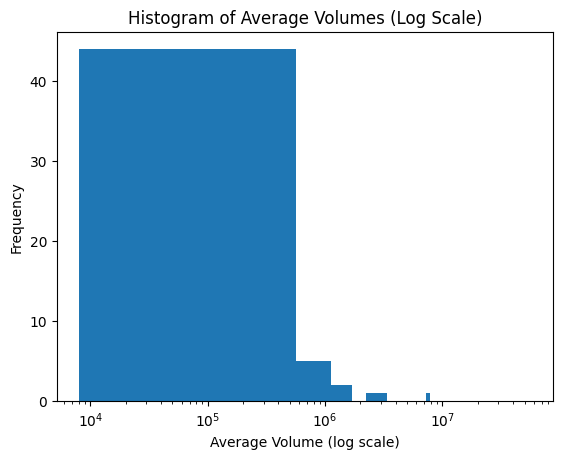

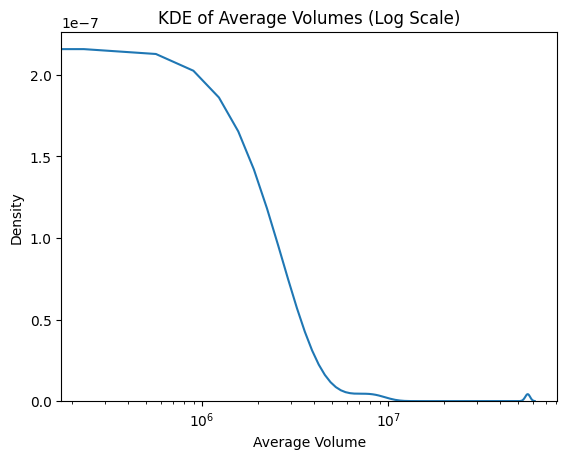

In [99]:
# data['yfinance_formatted'][['QQQ', 'IJJ']].xs('Volume', level='Price', axis=1)
min_vols = []
avg_vols = []
max_vols = []

for colnum in range(len(data_vol_filtered_1.columns)):
  # print(np.average(data_vol_filtered_1.iloc[:, colnum]))
  min_vols.append(np.min(data_vol_filtered_1.iloc[:, colnum]))
  avg_vols.append(np.average(data_vol_filtered_1.iloc[:, colnum]))
  max_vols.append(np.max(data_vol_filtered_1.iloc[:, colnum]))

plt.hist(avg_vols, bins=100)
plt.xscale('log')
plt.title("Histogram of Average Volumes (Log Scale)")
plt.xlabel("Average Volume (log scale)")
plt.ylabel("Frequency")
plt.show()

sns.kdeplot(avg_vols, bw_adjust=0.5)
plt.xscale('log')
plt.title("KDE of Average Volumes (Log Scale)")
plt.xlabel("Average Volume")
plt.show()

In [103]:
def step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1, liquidity_threshold = 10**5):
    avg_vols = data_vol_filtered_1.mean(axis=0)

    # find liquid tickers
    liquid_tickers = avg_vols[avg_vols > liquidity_threshold].index

    # similar to step 1, filter again using the tickers
    data_close_filtered_2 = data_close_filtered_1[liquid_tickers]
    data_open_filtered_2 = data_open_filtered_1[liquid_tickers]
    data_high_filtered_2 = data_high_filtered_1[liquid_tickers]
    data_low_filtered_2 = data_low_filtered_1[liquid_tickers]
    data_vol_filtered_2 = data_vol_filtered_1[liquid_tickers]
    data_original_format_filtered_2 = data_original_format_filtered_1[liquid_tickers]

    return data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2


data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)
data_close_filtered_2

,IFGL,RTH,PNQI,SHV,IGF,IJT,TUR,IEF,QQQ,QTEC,...,IEI,PPH,MBB,PHO,PEY,IGIB,DVY,AAXJ,PID,SCZ
Date,,,,,,,,,,,,,,,,,,,,,
2008-10-01,30.260000,29.650000,3.724000,110.309998,36.330002,30.100000,43.439999,89.279999,38.500000,16.030001,...,109.089996,33.500000,101.400002,17.820000,11.500000,46.009998,55.549999,42.340000,14.95,33.340000
2008-10-02,28.980000,28.600000,3.566000,110.440002,34.900002,28.520000,40.000000,89.779999,36.750000,15.190000,...,109.910004,33.060001,102.190002,16.410000,11.160000,46.025002,53.669998,40.700001,14.52,32.070000
2008-10-03,28.480000,28.330000,3.508000,110.320000,34.180000,27.775000,38.959999,90.120003,36.180000,14.960000,...,110.220001,32.849998,102.330002,16.120001,10.830000,45.700001,52.840000,40.169998,14.42,31.160000
2008-10-06,26.330000,27.366667,3.186000,110.279999,31.360001,26.965000,35.889999,90.849998,34.860001,14.040000,...,110.970001,31.655001,101.440002,15.000000,10.460000,45.724998,51.000000,37.020000,13.53,29.160000
2008-10-07,25.430000,26.116667,3.330000,110.360001,30.690001,25.395000,33.680000,90.779999,32.650002,13.290000,...,111.209999,30.424999,102.449997,14.360000,9.470000,45.735001,47.500000,35.700001,12.73,28.110001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-25,29.040001,110.660004,26.788000,110.389999,42.259998,101.599998,23.420000,100.790001,184.139999,78.940002,...,118.839996,64.059998,103.019997,31.920000,17.950001,52.889999,100.660004,70.690002,15.74,63.139999
2018-09-26,28.980000,111.150002,26.898001,110.410004,42.009998,100.459999,23.510000,101.120003,184.270004,78.599998,...,119.040001,63.939999,103.260002,31.760000,17.820000,53.049999,99.279999,70.739998,15.71,63.150002
2018-09-27,28.850000,111.400002,27.122000,110.430000,41.980000,100.599998,24.030001,101.120003,185.830002,78.940002,...,119.029999,64.260002,103.269997,31.709999,17.860001,53.090000,99.320000,71.010002,15.83,62.700001


# Find Co-Integrated Pairs

First, let's try to estimate the time we need.

In [104]:
import time
n_test_pairs = 10
start_time = time.time()
first_n_test_cols = data_original_format_filtered_2.columns.get_level_values('Ticker').unique()[:n_test_pairs]
scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2[first_n_test_cols])
end_time = time.time()
print(f"Execution time: {end_time - start_time:.2f} seconds")
seconds_per_pair = (end_time - start_time) / n_test_pairs
print(f"Seconds per pair: {seconds_per_pair:.2f}")

Completed 45 pairs
Execution time: 7.24 seconds
Seconds per pair: 0.72


In [112]:
from enum import unique


n_cols = len(data_original_format_filtered_2.columns.get_level_values('Ticker').unique())
max_cols = 30
if n_cols > max_cols and max_cols > 0:
    cols = data_original_format_filtered_2.columns.get_level_values('Ticker').unique()[:max_cols]
    n_cols = max_cols
else:
    cols = data_original_format_filtered_2.columns.get_level_values('Ticker').unique()
first_n_cols = data_original_format_filtered_2.columns.get_level_values('Ticker').unique()[:n_cols]
# combinatorially find number of unique pairs of columns
unique_pairs = n_cols * (n_cols - 1) / 2
expected_time = unique_pairs * seconds_per_pair
print(f"Expected time to run all pairs: {expected_time / 60:.2f} minutes")

Expected time to run all pairs: 5.25 minutes


In [113]:
from preprocessing.data_preprocessing import filter_pairs_data


In [114]:
%load_ext autoreload
%autoreload 2

from preprocessing.cointegration import find_cointegrated_pairs
from utils.visualization import plot_heatmap
from preprocessing.data_preprocessing import filter_pairs_data

# First, we'll try it for a smaller (random) subset of the data
import time
start_time = time.time()
scores, pvalues, pairs = find_cointegrated_pairs(data['yfinance_formatted'][first_n_cols])
# TODO: remove all perfectly cointegrated  variables where the error code shown below is given:
# /content/bsc-thesis/src/preprocessing/cointegration.py:62: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case. \ result = coint(S1, S2)
end_time = time.time()
print(f"Execution time: {end_time - start_time:.2f} seconds")
pairs_data = {key:value[1]  for (key, value) in pairs.items()}
pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
pairs_data_filtered

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Completed 435 pairs
Execution time: 66.68 seconds


[(('USIG', 'PPH'), np.float64(2.6213518550413317e-05)),
 (('USIG', 'PHO'), np.float64(0.0002540997299264048)),
 (('SHV', 'BBH'), np.float64(0.0007265501368268628)),
 (('SHV', 'PEY'), np.float64(0.0008390644259400168)),
 (('SHV', 'DVY'), np.float64(0.0012757233900976854)),
 (('SHV', 'QQQ'), np.float64(0.0014016938613905547)),
 (('SHV', 'ONEQ'), np.float64(0.001416928906774011)),
 (('SHV', 'IJT'), np.float64(0.0014508284926312003)),
 (('SHV', 'PDP'), np.float64(0.0015738718296940712)),
 (('SHV', 'IUSV'), np.float64(0.0016063982596577896)),
 (('SHV', 'PKW'), np.float64(0.0016487338852364348)),
 (('SHV', 'IBB'), np.float64(0.0017164476436032198)),
 (('SHV', 'QTEC'), np.float64(0.0019533363493516)),
 (('SHV', 'SOXX'), np.float64(0.0020928399322783517)),
 (('SHV', 'PRFZ'), np.float64(0.0022853588086710172)),
 (('SHV', 'TUR'), np.float64(0.002487596528460649)),
 (('IGIB', 'AAXJ'), np.float64(0.003384275558235718)),
 (('SHV', 'PPH'), np.float64(0.003913262558762743)),
 (('SHV', 'PHO'), np.floa

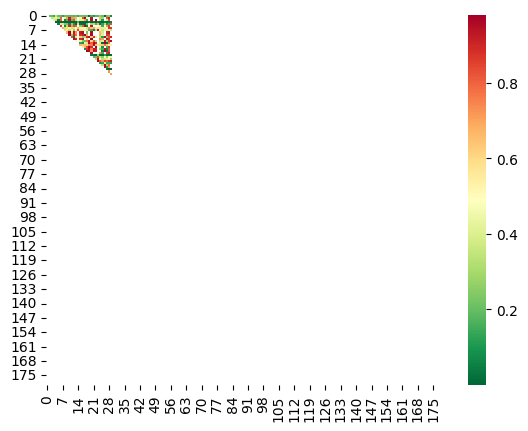

In [115]:
from utils.visualization import plot_heatmap
plot_heatmap(pvalues)

In [116]:
# Extract the most highly cointegrated pairs
ticker_a, ticker_b = pairs_data_filtered[0][0][0], pairs_data_filtered[0][0][1]
print(f"Most highly cointegrated pair: {ticker_a} and {ticker_b}")

pairs_timeseries = ({'S1_close':data_close_filtered_2[ticker_a],'S2_close':data_close_filtered_2[ticker_b]
                         ,'S1_open':data_open_filtered_2[ticker_a],'S2_open':data_open_filtered_2[ticker_b]
                         ,'S1_high':data_high_filtered_2[ticker_a],'S2_high':data_high_filtered_2[ticker_b]
                         ,'S1_low':data_low_filtered_2[ticker_a],'S2_low':data_low_filtered_2[ticker_b]
                         ,'S1_volume':data_vol_filtered_2[ticker_a],'S2_volume':data_vol_filtered_2[ticker_b]})
pairs_timeseries['S1_close'].plot(figsize=(15,7))
pairs_timeseries['S2_close'].plot(figsize=(15,7))
plt.legend([ticker_a, ticker_b])


Most highly cointegrated pair: USIG and PPH


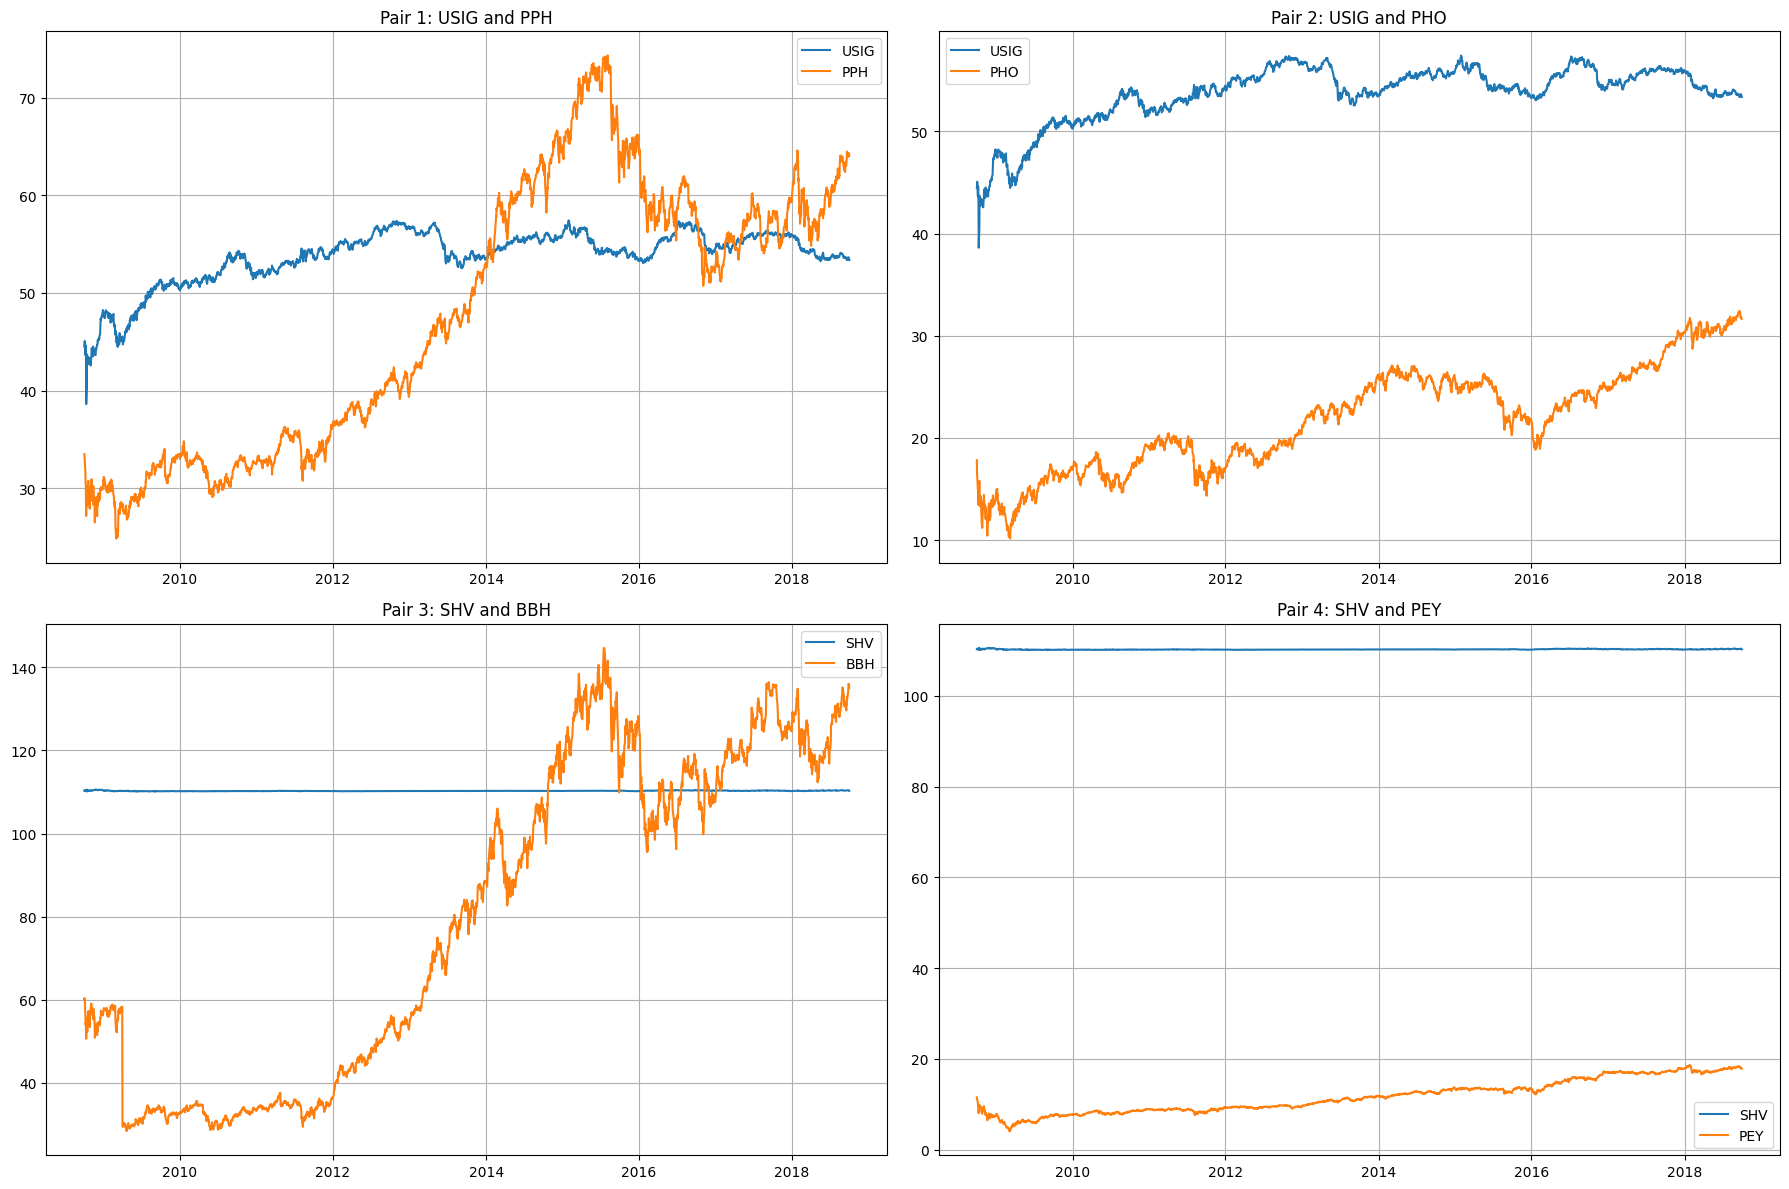

In [119]:
# Now Plot a grid of top 4 pairs
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
axs = axs.flatten()

for i in range(4):
    ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]

    s1_close = data_close_filtered_2[ticker_a]
    s2_close = data_close_filtered_2[ticker_b]

    axs[i].plot(s1_close, label=ticker_a)
    axs[i].plot(s2_close, label=ticker_b)
    axs[i].set_title(f'Pair {i+1}: {ticker_a} and {ticker_b}')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

# Training

Now, it's time for training.

Step 1: Adding Technical Indicators

In [123]:
pairs_timeseries_including_ta = add_technical_indicators(pairs_timeseries)
pairs_timeseries_final = add_OLS(pairs_timeseries_including_ta)

Now, let's take a look at the (hopefully) mean-reverting spread.

<ipython-input-131-2c131b61b7b8>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = -est.params[0]


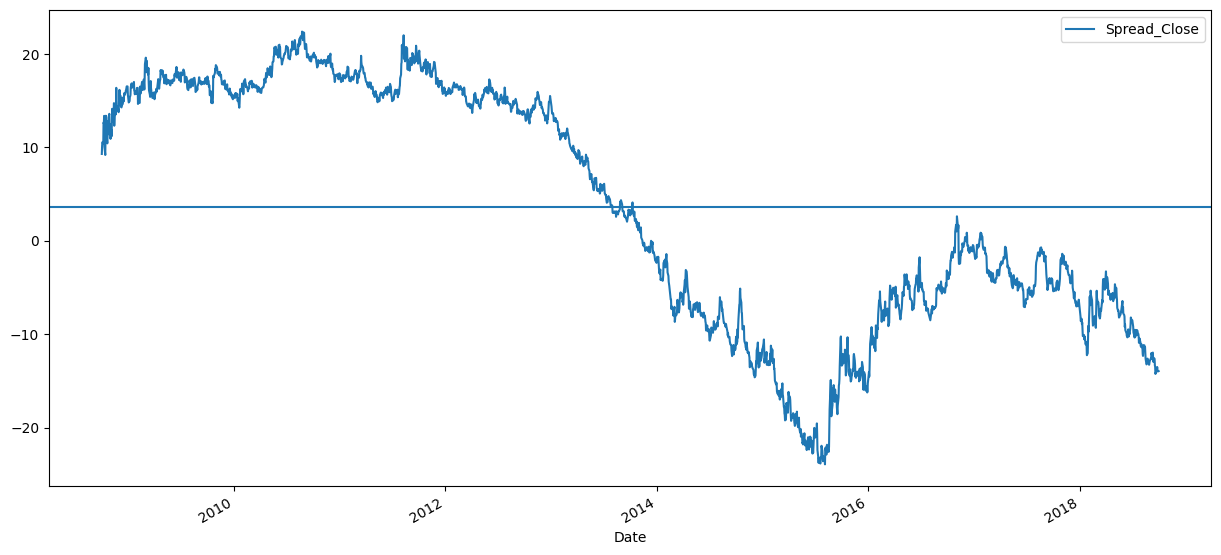

In [131]:
pairs_timeseries_including_ta['Spread_Close'].plot(figsize=(15,7))
plt.axhline(pairs_timeseries_including_ta['Spread_Close'].mean())
plt.legend(['Spread_Close'])

<ipython-input-132-a8dc7a2bade7>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_op = -est_op.params[0]
<ipython-input-132-a8dc7a2bade7>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_hi = -est_hi.params[0]
<ipython-input-132-a8dc7a2bade7>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_lo = -est_lo.params[0]


# Wavelet Denoising
Now, we apply simple wavelet denoising

In [139]:
def wav_den(ts_orig):
    (ca, cd) = pywt.dwt(ts_orig, 'db8')
    cat = pywt.threshold(ca, np.std(ca)/8, mode='soft')
    cdt = pywt.threshold(cd, np.std(cd)/8, mode='soft')
    ts_rec = pywt.idwt(cat, cdt, 'db8')
    return ts_rec[1:]

In [135]:
#Use MinMaxScaler to normalize Weighted Price to range from 0 to 1
cols = ['Spread_Close', 'Spread_Open', 'Spread_High', 'Spread_Low', 'S1_volume',
                                          'S2_volume', 'S1_rsi', 'S2_rsi', 'S1_mfi', 'S2_mfi', 'S1_adi', 'S2_adi',
                                           'S1_vpt', 'S2_vpt', 'S1_atr', 'S2_atr', 'S1_bb_ma', 'S2_bb_ma', 'S1_adx',
                                           'S2_adx', 'S1_ema', 'S2_ema', 'S1_macd', 'S2_macd', 'S1_dlr', 'S2_dlr']
lstm_pairs_timeseries = pd.DataFrame({'Spread_Close':pairs_timeseries_including_ta['Spread_Close'][30:],
                               'Spread_Open':pairs_timeseries_including_ta['Spread_Open'][30:],
                               'Spread_High':pairs_timeseries_including_ta['Spread_High'][30:],
                               'Spread_Low':pairs_timeseries_including_ta['Spread_Low'][30:],
                               'S1_volume':pairs_timeseries_including_ta['S1_volume'][30:],
                               'S2_volume':pairs_timeseries_including_ta['S2_volume'][30:],
                               'S1_rsi':pairs_timeseries_including_ta['S1_rsi'][30:],
                               'S2_rsi':pairs_timeseries_including_ta['S2_rsi'][30:],
                               'S1_mfi':pairs_timeseries_including_ta['S1_mfi'][30:],
                               'S2_mfi':pairs_timeseries_including_ta['S2_mfi'][30:],
                               'S1_adi':pairs_timeseries_including_ta['S1_adi'][30:],
                               'S2_adi':pairs_timeseries_including_ta['S2_adi'][30:],
                               'S1_vpt':pairs_timeseries_including_ta['S1_vpt'][30:],
                               'S2_vpt':pairs_timeseries_including_ta['S2_vpt'][30:],
                               'S1_atr':pairs_timeseries_including_ta['S1_atr'][30:],
                               'S2_atr':pairs_timeseries_including_ta['S2_atr'][30:],
                               'S1_bb_ma':pairs_timeseries_including_ta['S1_bb_ma'][30:],
                               'S2_bb_ma':pairs_timeseries_including_ta['S2_bb_ma'][30:],
                               'S1_adx':pairs_timeseries_including_ta['S1_adx'][30:],
                               'S2_adx':pairs_timeseries_including_ta['S2_adx'][30:],
                               'S1_ema':pairs_timeseries_including_ta['S1_ema'][30:],
                               'S2_ema':pairs_timeseries_including_ta['S2_ema'][30:],
                               'S1_macd':pairs_timeseries_including_ta['S1_macd'][30:],
                               'S2_macd':pairs_timeseries_including_ta['S2_macd'][30:],
                               'S1_dlr':pairs_timeseries_including_ta['S1_dlr'][30:],
                               'S2_dlr':pairs_timeseries_including_ta['S2_dlr'][30:]
                              }, columns = cols)

In [136]:
train_size = int(len(lstm_pairs_timeseries) * 0.9)
dev_size = int((len(lstm_pairs_timeseries) - train_size) * 0.5) - 30
test_size = len(lstm_pairs_timeseries) - train_size - dev_size
train, dev, test = lstm_pairs_timeseries[0:train_size], lstm_pairs_timeseries[train_size:train_size + dev_size], lstm_pairs_timeseries[train_size + dev_size:len(lstm_pairs_timeseries)]
print(len(train), len(dev), len(test))

2239 94 155


In [137]:
# first test whether wavelet denoising is working as expected
debug_train_den = pd.DataFrame(columns = cols)
col = cols[0]
train[col]

,Spread_Close
Date,
2008-11-12,14.745771
2008-11-13,12.325264
2008-11-14,13.247922
2008-11-17,14.216626
2008-11-18,13.531987
...,...
2017-09-28,-4.114448
2017-09-29,-4.579336
2017-10-02,-5.405840


In [140]:
train_den = pd.DataFrame(columns = cols)
for col in cols:
    train_den[col] = wav_den(train[col])

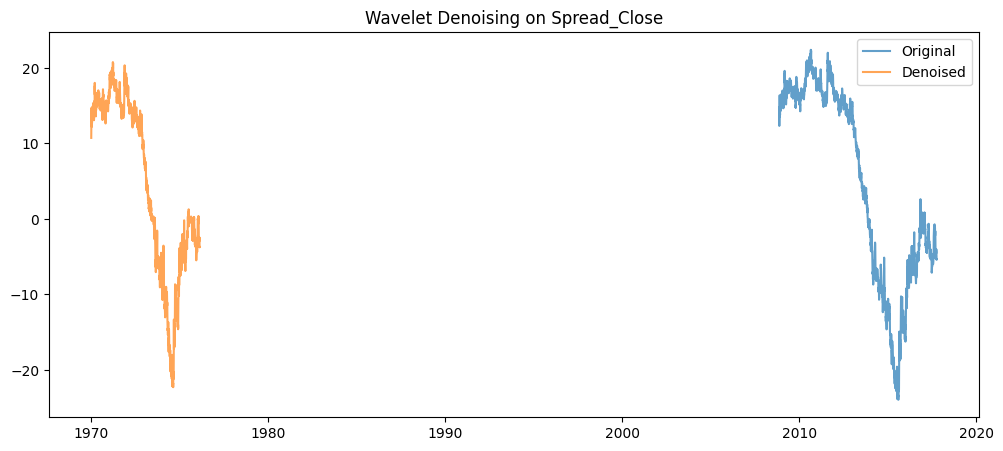

Original mean: 4.764935951800486
Denoised mean: 4.505753918172783
Original head: Date
2008-11-12    14.745771
2008-11-13    12.325264
2008-11-14    13.247922
2008-11-17    14.216626
2008-11-18    13.531987
2008-11-19    14.269837
2008-11-20    16.383739
2008-11-21    14.312618
2008-11-24    14.369396
2008-11-25    14.210276
Name: Spread_Close, dtype: float64
Denoised head: [10.73742566 11.65084929 12.57940382 11.92677631 12.68220697 14.72017117
 12.72918766 12.77230956 12.57322536 12.61621499]


In [141]:
# Possible columns:
# ['Spread_Close',
#  'Spread_Open',
#  'Spread_High',
#  'Spread_Low',
#  'S1_volume',
#  'S2_volume',
#  'S1_rsi',
#  'S2_rsi',
#  'S1_mfi',
#  'S2_mfi',
#  'S1_adi',
#  'S2_adi',
#  'S1_vpt',
#  'S2_vpt',
#  'S1_atr',
#  'S2_atr',
#  'S1_bb_ma',
#  'S2_bb_ma',
#  'S1_adx',
#  'S2_adx',
#  'S1_ema',
#  'S2_ema',
#  'S1_macd',
#  'S2_macd',
#  'S1_dlr',
#  'S2_dlr']
col = 'Spread_Close'
original = train[col]
denoised = wav_den(original)

plt.figure(figsize=(12, 5))
plt.plot(original, label='Original', alpha=0.7)
plt.plot(denoised, label='Denoised', alpha=0.7)
plt.legend()
plt.title(f'Wavelet Denoising on {col}')
plt.show()

print(f'Original mean: {original.mean()}')
print(f'Denoised mean: {denoised.mean()}')
print(f'Original head: {original[:10]}')
print(f'Denoised head: {denoised[:10]}')

In [ ]:
look_back = 1

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
# Create function for creating dataset with look back
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i, :]
        dataX.append(a)
        dataY.append(dataset[(i+1):(i+1+look_back), 0])
    print(len(dataY))
    return dataX, np.array(scaler.fit_transform(dataX)), dataY, np.array(scaler.fit_transform(dataY))

# Generate dataset for trainX, trainY, testX, testY
trainX_untr, trainX, trainY_untr, trainY = create_dataset(train_den.values, look_back)
devX_untr, devX, devY_untr, devY = create_dataset(dev.values, look_back)
testX_untr, testX, testY_untr, testY = create_dataset(test.values, look_back)

In [ ]:
def acc_metric(true_value, predicted_value):
    acc_met = 0.0
    m = len(true_value)
    for i in range(m):
        acc_met += mean_squared_error(true_value[i], predicted_value[i])
    acc_met /= m
    return np.sqrt(acc_met)